In [1]:
#Importando os pacotes
import pandas as pd
import re 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import shapiro
import statsmodels.api as sm
import numpy as np

In [2]:
dados = pd.read_excel('dados_limpos.xlsx')

In [3]:
dados.head(10)

,Preço,Bairro,Categoria,Quartos,Banheiros,R.A,Região,IDS
0,R$ 870.000,Botafogo,Apartamentos,1,1,Botafogo,Zona Sul,743.0
1,R$ 670.000,Jacarepaguá,Apartamentos,2,2,Jacarepaguá,Zona Oeste,476.0
2,R$ 690.000,Recreio dos Bandeirantes,Apartamentos,2,2,Barra da Tijuca,Zona Oeste,612.0
3,R$ 500.000,Copacabana,Apartamentos,1,2,Copacabana,Zona Sul,753.0
4,R$ 22.000,Santa Cruz,Casas,2,1,Santa Cruz,Zona Oeste,476.0
5,R$ 215.000,Parque Anchieta,Apartamentos,2,1,Anchieta,Zona Norte,540.0
6,R$ 390.000,Campo Grande,Casas,2,1,Campo Grande,Zona Oeste,518.0
7,R$ 400.000,Campo Grande,Casas,2,1,Campo Grande,Zona Oeste,518.0
8,R$ 650.000,Santíssimo,Casas,5 ou mais,4,Campo Grande,Zona Oeste,491.0
9,R$ 223.000,Guaratiba,Casas,3,3,Guaratiba,Zona Oeste,433.0


In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13336 entries, 0 to 13335
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Preço      13308 non-null  object 
 1   Bairro     13336 non-null  object 
 2   Categoria  13336 non-null  object 
 3   Quartos    11507 non-null  object 
 4   Banheiros  11497 non-null  object 
 5   R.A        13336 non-null  object 
 6   Região     13336 non-null  object 
 7   IDS        13334 non-null  float64
dtypes: float64(1), object(7)
memory usage: 833.6+ KB


Após uma primeira observação dos dados podemos ver que muitas linhas possuem valores em branco. Como o intuito é ajustar um modelo de regressão, nestes casos existem duas formas de proceder: imputar os dados de alguma forma ou apenas remover as linhas com os valores faltantes. Como a base possui mais de 10 mil linhas, não é necessário imputar os dados faltantes, procederá-se para remover as linhas que possuem valores faltantes. 

In [5]:
#Removendo as linhas com valores faltantes
dados_sem_valores_faltantes = dados.dropna()

In [6]:
print(f'Foram removidas: {dados.shape[0]-dados_sem_valores_faltantes.shape[0]} linhas')
print(f'O DataFrame possui agora: {dados_sem_valores_faltantes.shape[0]} linhas')

Foram removidas: 1852 linhas
O DataFrame possui agora: 11484 linhas


In [7]:
dados = dados_sem_valores_faltantes.copy()

In [8]:
numero_de_bairros = len(dados['Bairro'].unique())
numero_de_ra = len(dados['R.A'].unique())
print(f'Numero de bairros distintos: {numero_de_bairros}')
print(f'Numero de R.A\'s distintos: {numero_de_ra}')

Numero de bairros distintos: 141
Numero de R.A's distintos: 29


Quando uma variável categórica possui muitas categorias, o modelo de regressão pode enfrentar problemas como esparsidade dos dados onde o modelo pode ter dificuldade em generalizar bem para novos dados devido à falta de informações sobre algumas categorias. Também pode enfrentar problemas de interpretabilidade pois, com muitas categorias, interpretar o efeito de cada categoria individualmente pode se tornar difícil, especialmente se algumas categorias têm poucas observações. Tendo isso em mente, as variáveis/colunas "Bairro" e "R.A" serão removidas do DataFrame.

In [9]:
#Removendo as variáveis "Bairro" e "R.A"
dados.drop(columns=['Bairro','R.A'],inplace=True)


In [10]:
#DataFrame sem as colunas "Bairro" e "R.A"
dados.head(10)

,Preço,Categoria,Quartos,Banheiros,Região,IDS
0,R$ 870.000,Apartamentos,1,1,Zona Sul,743.0
1,R$ 670.000,Apartamentos,2,2,Zona Oeste,476.0
2,R$ 690.000,Apartamentos,2,2,Zona Oeste,612.0
3,R$ 500.000,Apartamentos,1,2,Zona Sul,753.0
4,R$ 22.000,Casas,2,1,Zona Oeste,476.0
5,R$ 215.000,Apartamentos,2,1,Zona Norte,540.0
6,R$ 390.000,Casas,2,1,Zona Oeste,518.0
7,R$ 400.000,Casas,2,1,Zona Oeste,518.0
8,R$ 650.000,Casas,5 ou mais,4,Zona Oeste,491.0
9,R$ 223.000,Casas,3,3,Zona Oeste,433.0


In [11]:
valores_unicos_preco = dados['Preço'].unique()
print("Valores únicos na coluna 'Preço':", valores_unicos_preco)

Valores únicos na coluna 'Preço': ['R$ 870.000' 'R$ 670.000' 'R$ 690.000' ... 'R$ 169.390' 'R$ 179.440'
 'R$ 209.304']


Como pode ser visto no 'dados.info()' utilizado no começo da análise e na saída dos valores únicos diretamente acima, o preço não está no formato ideal que seria float ou int. Os valores possuem um notação de moeda com o 'R$'. Logo, para fazer a análise será necessário remover essa notação de moeda.

In [12]:
# Função para remover 'R$' e formatação de decimais
extrair_numeros = lambda x: float(x.replace('R$', '').replace('.', '').replace(',', '.'))
dados['Preço'] = dados['Preço'].apply(extrair_numeros)
#Função para converter float em int
int_numeros = lambda x: int(x)
dados['Preço'] = dados['Preço'].apply(int_numeros)



Como podemos ver abaixo, os dados estão na formatação esperada.

In [13]:
valores_unicos_preco = dados['Preço'].unique()
print("Valores únicos na coluna 'Preço':", valores_unicos_preco)

Valores únicos na coluna 'Preço': [870000 670000 690000 ... 169390 179440 209304]


In [14]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11484 entries, 0 to 13335
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Preço      11484 non-null  int64  
 1   Categoria  11484 non-null  object 
 2   Quartos    11484 non-null  object 
 3   Banheiros  11484 non-null  object 
 4   Região     11484 non-null  object 
 5   IDS        11484 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 628.0+ KB


Utilizando o 'dados.describe' pode-se obter um resumo da variáveis numéricas do DataFrame como: média, mínimo, máximo e os quartis. Sobre a variável resposta que será o preço, pode ser visto acima que o preço mínimo é: 0, provavelmente isso ocorre por conta de uma inserção errada de valores por parte do usuário no momento em que foi utilizado o site. Sobre a média e os quartis, nota-se que os valores estão muito acima dos esperados para o padrão da cidade, após uma breve pesquisa em sites de venda de imóeveis, foi encontrado valores que variavam em média entre R$150.000 e R$700.000. 

In [15]:
#Fazer os dados ficarem em formatação padrão ao invés de notação científica
pd.options.display.float_format = '{:.2f}'.format
resumo = dados.describe()
print(resumo)


             Preço      IDS
count     11484.00 11484.00
mean    2403209.73   715.13
std     3095227.94   101.24
min           0.00   369.00
25%      660000.00   629.00
50%     1550000.00   753.00
75%     3200000.00   795.00
max   125000000.00   854.00


Pode ser visto abaixo que cerca de 82% dos imóveis se concentram na Zona Sul e Zona Oeste. A Zona Sul é a região da cidade onde são econtrados imóveis com altos preços, já na Zona Oeste existem bairros com preços altos e bairros com preços muito baixos, entende-se que boa parte da amostra da Zona Oeste possa vir de bairros com preços altos, como a Barra da Tijuca, por exemplo. Isso explicaria os dados estarem inflacionados. Outro fator que pode explicar é o fato desses dados terem sido coletados em um site de anúnico de imóveis que tende a por imóveis com anúncios promovidos como prioridade, logo, quem vende imóveis mais caros tende a pagar mais para que seus imóveis tenham destaque.

O ideal seria o dataframe conter categorias mais balanceadas na região, para isso, seria necessário balancear os dados de alguma forma, mas a príncipio este projeto foca em fazer uma abordagem mais simplista. Então, vamos apenas ignorar este fato. Para um trabalho futuro essa questão poderá ser considerada.

In [16]:
frequencia_bairro = dados['Região'].value_counts()

print(frequencia_bairro)
porcentagem_zonasul_zonaoeste = round(((frequencia_bairro[0]+frequencia_bairro[1])/sum(frequencia_bairro))*100,2)
print(f'Cerca de: {porcentagem_zonasul_zonaoeste} % dos dados estão na Zona Sul e Zona Oeste')

Região
Zona Oeste      4773
Zona Sul        4656
Zona Norte      1900
Zona Central     155
Name: count, dtype: int64
Cerca de: 82.11 % dos dados estão na Zona Sul e Zona Oeste


Sobre a questão do valor com entrada 0, vamos olhar os 10 mais baratos:

In [17]:
dados.nsmallest(10, 'Preço')

,Preço,Categoria,Quartos,Banheiros,Região,IDS
233,0,Casas,5 ou mais,5 ou mais,Zona Oeste,651.00
10653,35,Apartamentos,1,1,Zona Oeste,545.00
1131,50,Apartamentos,2,1,Zona Oeste,518.00
1292,55,Casas,2,2,Zona Norte,687.00
12897,110,Casas,3,1,Zona Oeste,525.00
232,150,Apartamentos,1,1,Zona Oeste,476.00
7027,250,Casas,2,3,Zona Norte,588.00
11266,270,Apartamentos,2,1,Zona Norte,610.00
516,280,Apartamentos,2,2,Zona Norte,687.00
67,300,Casas,5 ou mais,5 ou mais,Zona Oeste,525.00


Como podemos ver, os 10 mais baratos são, de fato, valores baixos, isso deve-se ao fato de em nossa base não possuírmos informações a respeito de se é aluguel ou venda. Apenas por motivos didáticos, para considerar apenas vendas, a base será filtrada por preços acima de 100000, esta ação pode introduzir um viés em nossa análise, fazendo com que nosso modelo não seja o ideal. Reitero que o foco do projeto é ser o mais simplista e, por isso, será feito desta maneira. Esse valor foi escolhido com base em uma breve pesquisa em sites de imóveis a venda, como citado acima. 

In [18]:
dados_100000 = dados[dados['Preço']>=100000]

In [19]:
#Quantidade de linhas removidas
qtd_linhas_removidas = dados.shape[0]-dados_100000.shape[0]
print(f'Foram removidas: {qtd_linhas_removidas} linhas')
print(f'Que corresponde a: {round((qtd_linhas_removidas*100)/dados.shape[0],2)}% dos dados')

Foram removidas: 764 linhas
Que corresponde a: 6.65% dos dados


Utilizando o .describe() novamente podemos ver que os valores médio e dos quartis aumentaram, o que era de se esperar, pois foram removidos os valores abaixo de 100.000. 

In [20]:
dados = dados_100000.copy()
dados.describe()

,Preço,IDS
count,10720.00,10720.00
mean,2573627.58,716.78
std,3134753.12,100.76
min,100000.00,369.00
25%,800000.00,635.00
50%,1690000.00,753.00
75%,3350000.00,795.00
max,125000000.00,854.00


In [21]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10720 entries, 0 to 13335
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Preço      10720 non-null  int64  
 1   Categoria  10720 non-null  object 
 2   Quartos    10720 non-null  object 
 3   Banheiros  10720 non-null  object 
 4   Região     10720 non-null  object 
 5   IDS        10720 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 586.2+ KB


Após a limpeza final dos dados, podemos começar a explorar melhor a base de dados. Para isso, será feito um gráfico boxplot da Região e do Preço para entender melhor como essas variáveis se comportam. 

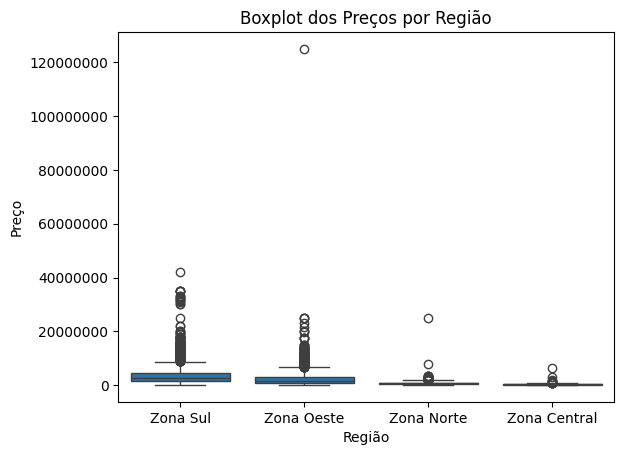

In [22]:


# Plotar boxplot para cada categoria na coluna "região"
sns.boxplot(data=dados, x='Região', y='Preço')

# Desativar a notação científica no eixo y
plt.ticklabel_format(style='plain', axis='y')

# Adicionar rótulos aos eixos
plt.xlabel('Região')
plt.ylabel('Preço')

# Adicionando um título ao gráfico
plt.title('Boxplot dos Preços por Região')

# Mostrar o gráfico
plt.show()


Como podemos ver acima, valores outliers (extremos) estão distorcendo os nossos dados. Para resolver este problema, será utilizado o limite de 1.5 * o intervalo entre os quartis para filtrar esse valores. 

In [23]:
# Calcule as estatísticas descritivas (incluindo quartis) da coluna 'Região'
descritivo = dados['Preço'].describe()

# Calcule o intervalo interquartil (IQR)
IQR = descritivo['75%'] - descritivo['25%']

# Defina os limites para identificar outliers
limite_inferior = descritivo['25%'] - 1.5 * IQR
limite_superior = descritivo['75%'] + 1.5 * IQR

# Remova os outliers
dados = dados[(dados['Preço'] >= limite_inferior) & (dados['Preço'] <= limite_superior)]


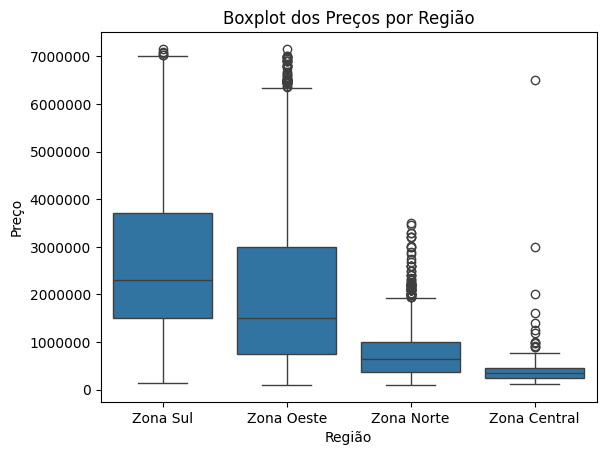

In [24]:
# Plotar boxplot para cada categoria na coluna "região"
sns.boxplot(data=dados, x='Região', y='Preço')

# Desativar a notação científica no eixo y
plt.ticklabel_format(style='plain', axis='y')

# Adicionar rótulos aos eixos
plt.xlabel('Região')
plt.ylabel('Preço')

# Adicionando um título ao gráfico
plt.title('Boxplot dos Preços por Região')

# Mostrar o gráfico
plt.show()


Após filtrar os valores acima de 1.5 vezes o intervalo dos quartis, podemos análisar o boxplot. Ainda existem valores outliers, porém esses valores se devem a estrutura dos dados e por isso serão mantidos.

Os preços dos imóveis na Zona Sul e Zona Oeste são de fato os maiores em nossa base. O que pode explicar os imóveis da Zona Central serem os mais  baixos é o seu tamanho, muitos imóveis da Zona Central são salas comerciais. Se tivéssemos em nossa base o preço do metro quadrado ao invés de apenas preço, existiria a chance de a Zona Central possuir um boxplot mais parecido  com o da Zona Norte ou até com valores mais elevados.

Abaixo podemos ver os valores exatos de min, max, média e quartis para cada categoria.

In [25]:
descritivo_por_regiao = dados.groupby('Região')['Preço'].describe()
print(descritivo_por_regiao)

               count       mean        std       min        25%        50%  \
Região                                                                       
Zona Central  133.00  476007.74  639191.50 122500.00  250000.00  350000.00   
Zona Norte   1721.00  777799.48  531751.41 101422.00  370000.00  650000.00   
Zona Oeste   4357.00 1999773.45 1558710.35 100000.00  750000.00 1500000.00   
Zona Sul     3941.00 2722894.83 1619770.92 140000.00 1500000.00 2300000.00   

                    75%        max  
Região                              
Zona Central  460000.00 6500000.00  
Zona Norte    999000.00 3500000.00  
Zona Oeste   2990000.00 7155750.00  
Zona Sul     3700000.00 7149000.00  


Também, foi feito um box plot para a Categoria e para o Preço. Como podemos ver abaixo, os preços dos apartamentos estão mais altos que os preços das casas. Normalmente espera-se que casas tenham o preço mais alto que dos apartamentos, vamos investigar mais adiante os possíveis motivos.

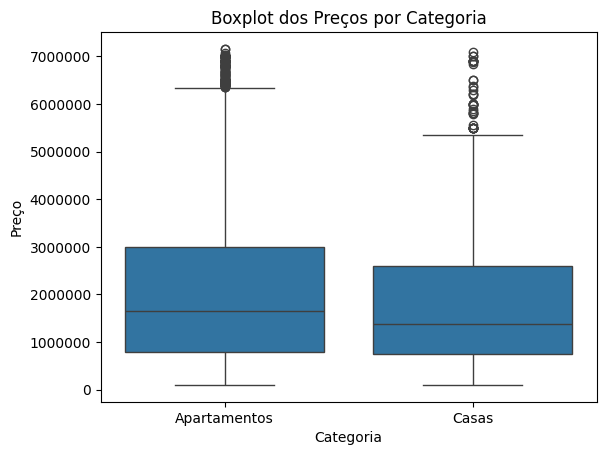

In [26]:
# Plotando boxplot para cada categoria na coluna "região"
sns.boxplot(data=dados, x='Categoria', y='Preço')

# Desativando a notação científica no eixo y
plt.ticklabel_format(style='plain', axis='y')

# Adicionando rótulos aos eixos
plt.xlabel('Categoria')
plt.ylabel('Preço')

# Adicionando um título ao gráfico
plt.title('Boxplot dos Preços por Categoria')

# Mostrar o gráfico
plt.show()

Para entender melhor, vamos fazer uma tabela de contingência e ver a proporção de apartamentos e casas em cada região, pois como visto no Boxplot de preço e região, a região impacta no preço dos imóveis.

Como podemos ver abaixo, 45% dos Apartamentos da nossa base estão na Zona Sul, enquanto 15% das Casas estão na Zona Sul, isso pode explicar o motivo de o preço dos apartamentos serem mais caros, sabendo que a Zona Sul é onde se encontram os imóveis com o maior valor.

In [27]:
# Agrupando os dados por 'Categoria' e 'Região' e contando o número de ocorrências em cada grupo
contagem_por_categoria_regiao = dados.groupby(['Categoria', 'Região']).size().reset_index(name='Contagem')

# Exibindo o resultado
print(contagem_por_categoria_regiao)


      Categoria        Região  Contagem
0  Apartamentos  Zona Central       109
1  Apartamentos    Zona Norte      1168
2  Apartamentos    Zona Oeste      3038
3  Apartamentos      Zona Sul      3602
4         Casas  Zona Central        24
5         Casas    Zona Norte       553
6         Casas    Zona Oeste      1319
7         Casas      Zona Sul       339


In [28]:

# Criando tabela de contingência
tabela_contingencia = pd.crosstab(index=contagem_por_categoria_regiao['Categoria'], 
                                  columns=contagem_por_categoria_regiao['Região'],
                                  values=contagem_por_categoria_regiao['Contagem'],
                                  aggfunc='sum',
                                  normalize='index')
# Multiplicando por 100 e formatando como percentual
tabela_contingencia_porcentagem = tabela_contingencia* 100
tabela_contingencia_porcentagem = tabela_contingencia_porcentagem.applymap(lambda x: "{:.2f}%".format(x))

# Exibindo a tabela de contingência com porcentagens por linha em formato de %
print(tabela_contingencia_porcentagem)



Região       Zona Central Zona Norte Zona Oeste Zona Sul
Categoria                                               
Apartamentos        1.38%     14.75%     38.37%   45.50%
Casas               1.07%     24.74%     59.02%   15.17%


In [29]:
valor_apartamentos_zona_sul = tabela_contingencia_porcentagem.loc["Apartamentos", "Zona Sul"]
valor_casas_zona_sul = tabela_contingencia_porcentagem.loc["Casas", "Zona Sul"]
print(f"Porcentagem de Apartamentos na Zona Sul:{valor_apartamentos_zona_sul}" )
print(f"Porcentagem de Casas na Zona Sul:{valor_casas_zona_sul}" )


Porcentagem de Apartamentos na Zona Sul:45.50%
Porcentagem de Casas na Zona Sul:15.17%


Também foi feito um boxplot para o Preço e Quartos. Como podemos ver: o preço dos imóveis cresce a medida que  o número de quartos também cresce, a exceção do "5 ou mais" que possui os valores menores que o 4 quartos.

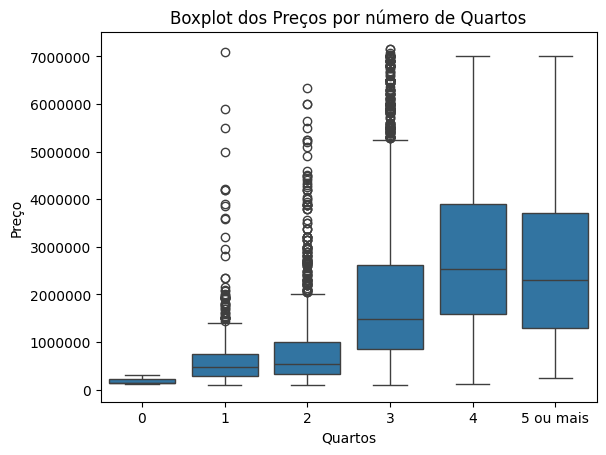

In [30]:
# Definindo a ordem desejada das categorias
ordem_categorias = ['0', '1', '2', '3', '4', '5 ou mais']
df = dados
# Criar uma nova coluna categórica com a ordem desejada
df['Quartos'] = pd.Categorical(df['Quartos'], categories=ordem_categorias, ordered=True)

# Plotando boxplot para cada categoria na coluna "Quartos"
sns.boxplot(data=df, x='Quartos', y='Preço')

# Desativando a notação científica no eixo y
plt.ticklabel_format(style='plain', axis='y')

# Adicionando rótulos aos eixos
plt.xlabel('Quartos')
plt.ylabel('Preço')

# Adicionando um título ao gráfico
plt.title('Boxplot dos Preços por número de Quartos')

# Mostrar o gráfico
plt.show()

Abaixo podemos ver os valores exatos:

In [31]:
descritivo_por_quartos = dados.groupby('Quartos')['Preço'].describe()
print(descritivo_por_quartos)

            count       mean        std       min        25%        50%  \
Quartos                                                                   
0            7.00  186142.86   69573.53 120000.00  147000.00  150000.00   
1          514.00  679798.14  768401.91 100000.00  290000.00  470000.00   
2         1718.00  825601.51  830981.13 100000.00  320000.00  529799.50   
3         3656.00 1953777.47 1484578.08 101422.00  850000.00 1490000.00   
4         3239.00 2854799.82 1603218.53 120000.00 1580000.00 2543000.00   
5 ou mais 1018.00 2639522.31 1553350.99 250000.00 1300000.00 2300000.00   

                 75%        max  
Quartos                          
0          219500.00  300000.00  
1          750000.00 7098165.00  
2          999997.50 6330001.00  
3         2612000.00 7155750.00  
4         3900000.00 7000000.00  
5 ou mais 3700000.00 7000000.00  


Foi feito também um boxplot para o 'Preço' e 'Banheiros'. E assim como o número de quartos, o preço aumenta a medida que o número de banheiros cresce.

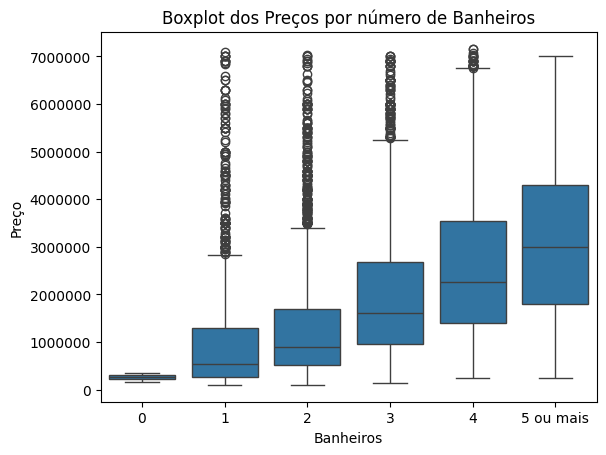

In [32]:
# Definindo a ordem desejada das categorias
ordem_categorias = ['0', '1', '2', '3', '4', '5 ou mais']
df = dados
# Criando uma nova coluna categórica com a ordem desejada
df['Banheiros'] = pd.Categorical(df['Banheiros'], categories=ordem_categorias, ordered=True)

# Plotando boxplot para cada categoria na coluna "Quartos"
sns.boxplot(data=df, x='Banheiros', y='Preço')

# Desativando a notação científica no eixo y
plt.ticklabel_format(style='plain', axis='y')

# Adicionando rótulos aos eixos
plt.xlabel('Banheiros')
plt.ylabel('Preço')

# Adicionando um título ao gráfico
plt.title('Boxplot dos Preços por número de Banheiros')


# Mostrar o gráfico
plt.show()

Para entender sobre a variável IDS. Será feito abaixo um gráfico de dispersão entre o Preço e o IDS.

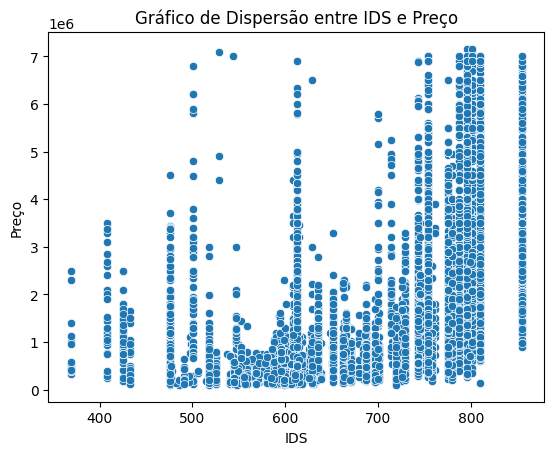

In [33]:
sns.scatterplot(x='IDS', y='Preço', data=dados)
plt.xlabel('IDS')
plt.ylabel('Preço')
plt.title('Gráfico de Dispersão entre IDS e Preço')
plt.show()

Como podemos ver, no gráfico de dipersão acima não se encontra uma relação aparente entre o preço e o IDS, se nos esforçarmos a ver podemos encontrar um possível crescimento no preço e ao mesmo tempo um crescimento na variação do preço. Para verificar se o problema era a variação dos dados, tentou-se realizar transformações nos dados, sem sucesso. Os resultados foram omitidos para poupar espaço no projeto. Por fim, entende-se que o efeito do IDS no preço não é constante e pode variar dependendo de outros fatores. Por este motivo, opta-se por desconsiderar esta variável na hora de ajustar o modelo.

In [34]:
#Removendo a variável IDS
dados = dados.drop(columns='IDS')

In [35]:
dados.head(10)

,Preço,Categoria,Quartos,Banheiros,Região
0,870000,Apartamentos,1,1,Zona Sul
1,670000,Apartamentos,2,2,Zona Oeste
2,690000,Apartamentos,2,2,Zona Oeste
3,500000,Apartamentos,1,2,Zona Sul
5,215000,Apartamentos,2,1,Zona Norte
6,390000,Casas,2,1,Zona Oeste
7,400000,Casas,2,1,Zona Oeste
8,650000,Casas,5 ou mais,4,Zona Oeste
9,223000,Casas,3,3,Zona Oeste
10,750000,Apartamentos,2,1,Zona Sul


Uma media importante de se verificar entre as variáveis é a correlação, para  para isso sera feito o calculo da correlação de Spearman entre a variável Preço e as demais variáveis.  A correlação de Spearman fornece uma medida da força e direção da relação monotônica entre as variáveis. Um valor próximo de 1 indica uma forte relação monotônica positiva, enquanto um valor próximo de -1 indica uma forte relação monotônica negativa.

In [36]:


# Dicionário para armazenar os resultados
results_dict = {'Variável': [], 'Correlação de Spearman': [], 'P-valor': [], 'Significância': []}

# Calculando a correlação de Spearman para cada par de variáveis em relação à variável "Preço"
variables = ['Categoria', 'Quartos', 'Banheiros', 'Região']
for var in variables:
    correlation, p_value = spearmanr(dados['Preço'], dados[var])
    
    # Verificando a significância do resultado
    alpha = 0.05  # Nível de significância comum de 0,05
    if p_value <= alpha:
        significancia = 'Sim'
    else:
        significancia = 'Não'
    
    # Armazenando os resultados no dicionário
    results_dict['Variável'].append(var)
    results_dict['Correlação de Spearman'].append(correlation)
    results_dict['P-valor'].append(p_value)
    results_dict['Significância'].append(significancia)

# Criando DataFrame pandas com os resultados
df_results = pd.DataFrame(results_dict)

# Exibir a tabela
print(df_results)

    Variável  Correlação de Spearman  P-valor Significância
0  Categoria                   -0.06     0.00           Sim
1    Quartos                    0.53     0.00           Sim
2  Banheiros                    0.54     0.00           Sim
3     Região                    0.48     0.00           Sim


Como pode ser visto, todas as variáveis possuem uma correlação significativa com o preço, no caso da categoria, essa correlação é fraca, ela será mantida para ver como se comporta no ajuste do modelo.

Antes de ajustar o modelo, uma das suposições que deve ser verificada é a suposição de normalidade da variável resposta. Pode-se verificar esta suposição através do teste de Shapiro-Wilk, para realizar este teste, faz-se um teste de hipótese em que se tem como hipótese nula: Os dados não seguem uma distribuição normal. Abaixo pode se ver teste. 

In [37]:

# Executando o teste de Shapiro-Wilk
stat, p_value = shapiro(dados['Preço'])

# Imprimindo o resultado do teste
print("Estatística de Shapiro-Wilk:", stat)
print("Valor p:", p_value)

# Verificando a significância do resultado
alpha = 0.05  # Nível de significância comum de 0,05
if p_value <= alpha:
    print("Rejeitamos a hipótese nula - os dados NÃO seguem uma distribuição normal.")
else:
    print("Falhamos em rejeitar a hipótese nula - os dados seguem uma distribuição normal.")

Estatística de Shapiro-Wilk: 0.8959425091743469
Valor p: 0.0
Rejeitamos a hipótese nula - os dados NÃO seguem uma distribuição normal.


c:\Users\Ruan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Como pode ser visto, a variável resposta NÃO segue uma distribuição normal. Sabendo disso, é comum prosseguir de duas formas, realizar uma transformação na variável para tentar chegar na normalidade ou ajustar o modelo mesmo não sendo normal. A segunda abordagem pode fazer as inferências sobre os parâmetros serem afetadas, por isso, antes de ajustar o modelo será feita uma transformação com o intuito de chegar a normalidade da variável resposta.

Abaixo será feito um gráfico Histograma com o intuito de descobrir como a variável resposta se comporta.

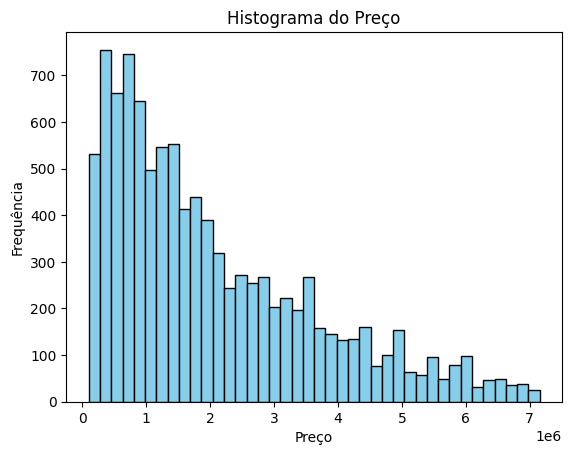

In [38]:
# Plotando o histograma da variável "Preço"
plt.hist(dados['Preço'], bins=40, color='skyblue', edgecolor='black')
#plt.ticklabel_format(style='plain', axis='x')
# Adicionando rótulos e título
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.title('Histograma do Preço')

# Exibir o histograma
plt.show()

Após a análise do Histograma, nota-se que a distribuição da variável resposta se assemelha a uma distribuição Qui-Quadrado. Tendo isso em mente, serão testadas as transformações mais comuns quando se tem a variável resposta com essa distribuição. São elas: transformação logarítmica, transformação raíz quadrada e transformação box-cox.

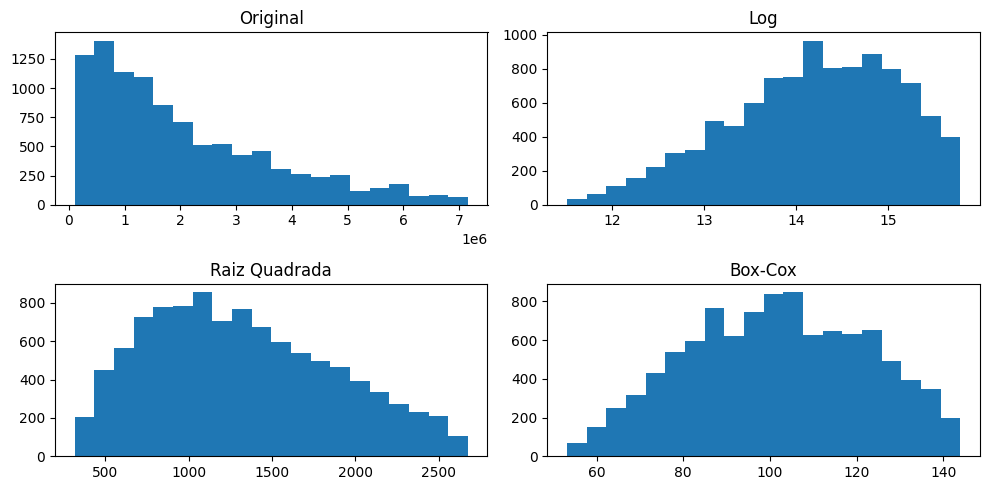

In [39]:

# Variável resposta
y = dados['Preço']

# Transformações
y_log = np.log(y)
y_reciproco = 1 / y
y_raiz_quadrada = np.sqrt(y)

# Transformação Box-Cox
from scipy.stats import boxcox
y_boxcox , lambda_otimo= boxcox(y)

# Criando histogramas para cada transformação
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.hist(y, bins=20)
plt.title('Original')

plt.subplot(2, 2, 2)
plt.hist(y_log, bins=20)
plt.title('Log')

plt.subplot(2, 2, 3)
plt.hist(y_raiz_quadrada, bins=20)
plt.title('Raiz Quadrada')

plt.subplot(2, 2, 4)
plt.hist(y_boxcox, bins=20)
plt.title('Box-Cox')

plt.tight_layout()
plt.show()

In [40]:


# Lista das variáveis transformadas e seus respectivos nomes
transformations = {
    'y_log': y_log,
    'y_raiz_quadrada': y_raiz_quadrada,
    'y_boxcox': y_boxcox
}

# Dicionário para armazenar os resultados do teste de Shapiro-Wilk
shapiro_results = {}

# Executando o teste de Shapiro-Wilk para cada transformação e armazenar os resultados
for transformation_name, transformation_data in transformations.items():
    stat, p_value = shapiro(transformation_data)
    shapiro_results[transformation_name] = {'Estatística de Shapiro-Wilk': stat, 'Valor p': p_value}

# Criando DataFrame pandas com os resultados
df_results = pd.DataFrame.from_dict(shapiro_results, orient='index')

# Interpretando os resultados com base no nível de significância
alpha = 0.05
df_results['Hipótese nula'] = df_results['Valor p'].apply(lambda x: 'Rejeitada' if x <= alpha else 'Não rejeitada')

# Exibir a tabela
print(df_results)

print('Nenhuma transformação fez a variável resposta chegar a normalidade')


                 Estatística de Shapiro-Wilk  Valor p Hipótese nula
y_log                                   0.97     0.00     Rejeitada
y_raiz_quadrada                         0.97     0.00     Rejeitada
y_boxcox                                0.99     0.00     Rejeitada
Nenhuma transformação fez a variável resposta chegar a normalidade


Como pode ser visto, nenhuma transformação fez a variável resposta chegar a normalidade, entretanto os valores da estatística de Shapiro-Wilk melhoraram se comparado com a variável antes da transformação, pois quando os dados são provenientes de uma distribuição normal, a estatística de Shapiro-Wilk é mais próxima de 1. Quando ajustamos o modelo com a variável transformada, a interpretação dos coeficientes do modelo muda de acordo com a transformação aplicada. Apesar de ter melhorado, como a normalidade não foi alcançada e a interpretação se torna mais complexa, por motivos didáticos, o modelo será ajustado sem nenhuma transformação ser aplicada. 

Um ultima coisa que devemos verificar é possíveis problemas de multicolinearidade, para isso será feito a matriz de correlação entre as variáveis explicativas.

In [41]:

# Criando variáveis dummy para as variáveis categóricas
dados_encoded = pd.get_dummies(dados, columns=['Categoria', 'Quartos', 'Banheiros', 'Região'])

# Selecionando as variáveis explicativas
X = dados_encoded[['Categoria_Apartamentos', 'Quartos_1', 'Quartos_2', 'Quartos_3', 'Quartos_4', 'Quartos_5 ou mais', 'Banheiros_1', 'Banheiros_2', 'Banheiros_3', 'Banheiros_4', 'Banheiros_5 ou mais', 'Região_Zona Oeste', 'Região_Zona Norte', 'Região_Zona Sul','Região_Zona Central']]

# Calculando a matriz de correlação entre variáveis
correlation_matrix = X.corr()

print(correlation_matrix)


                        Categoria_Apartamentos  Quartos_1  Quartos_2  \
Categoria_Apartamentos                    1.00       0.09       0.13   
Quartos_1                                 0.09       1.00      -0.10   
Quartos_2                                 0.13      -0.10       1.00   
Quartos_3                                 0.13      -0.17      -0.34   
Quartos_4                                -0.06      -0.16      -0.31   
Quartos_5 ou mais                        -0.33      -0.08      -0.15   
Banheiros_1                               0.09       0.44       0.24   
Banheiros_2                               0.09      -0.05       0.25   
Banheiros_3                               0.06      -0.12      -0.09   
Banheiros_4                              -0.02      -0.11      -0.18   
Banheiros_5 ou mais                      -0.22      -0.11      -0.22   
Região_Zona Oeste                        -0.17      -0.11      -0.02   
Região_Zona Norte                        -0.11       0.01       

Como a matriz é grande, vamos verificar possíveis correlações altas através do script abaixo.

In [42]:

# Usando numpy.triu() para selecionar a parte superior da matriz (excluindo a diagonal principal)
upper_triangle = np.triu(correlation_matrix, k=1)

# Criando máscaras booleanas para os valores maiores que 0.8 e menores que -0.8
mask_greater_than_08 = upper_triangle > 0.8
mask_less_than_minus_08 = upper_triangle < -0.8

# Combinando as máscaras usando a operação lógica OR (|)
combined_mask = mask_greater_than_08 | mask_less_than_minus_08

# Usando a máscara combinada para selecionar os valores desejados
high_correlation_values = upper_triangle[combined_mask]


# Verificando se high_correlation_values está vazio
if len(high_correlation_values) == 0:
    print("Não foram encontradas correlações altas entre as variáveis.")
else:
    print("Valores de correlação maiores que 0.8 ou menores que -0.8:")
    print(high_correlation_values)



Não foram encontradas correlações altas entre as variáveis.


Como pode ser visto, não encontramos correlação alta entre as variáveis explicativas. Então podemos dizer que não há indícios de multicolinearidade.

Agora podemos ajustar o modelo de regressão linear.

In [43]:
# Criando variáveis dummy para as variáveis categóricas
dados_encoded = pd.get_dummies(dados, drop_first= True, dtype=float)

# Separar as variáveis explicativas e a variável resposta
X = dados_encoded.drop(columns=['Preço'])
y = dados_encoded['Preço']


# Inicializando o modelo de regressão linear
model = sm.OLS(y, sm.add_constant(X))  # Adicionar uma constante para o termo de interceptação
results = model.fit()
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# Imprimir um resumo do modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preço   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     564.5
Date:                Fri, 17 May 2024   Prob (F-statistic):               0.00
Time:                        15:38:15   Log-Likelihood:            -1.5658e+05
No. Observations:               10152   AIC:                         3.132e+05
Df Residuals:                   10137   BIC:                         3.133e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -7.256e+04   8

Como podemos ver acima através do R-squared, nosso modelo explica pouco dos dados. Podemos ver também que a constante não é significativa, de fato não faz sentido nesta abordagem ter uma constante, dado que nossos dados são categóricos, por isso, a primeira coisa a se fazer é remover a constante e ver como o modelo se comporta.

In [44]:
# Criando variáveis dummy para as variáveis categóricas
dados_encoded = pd.get_dummies(dados, drop_first= True, dtype=float)

# Separando as variáveis explicativas e a variável resposta
X = dados_encoded.drop(columns=['Preço'])
y = dados_encoded['Preço']


# Inicializando o modelo de regressão linear
model = sm.OLS(y, X)  # Modelo sem a constante
results = model.fit()
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# Imprimir um resumo do modelo
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Preço   R-squared (uncentered):                   0.786
Model:                            OLS   Adj. R-squared (uncentered):              0.785
Method:                 Least Squares   F-statistic:                              2656.
Date:                Fri, 17 May 2024   Prob (F-statistic):                        0.00
Time:                        15:38:15   Log-Likelihood:                     -1.5658e+05
No. Observations:               10152   AIC:                                  3.132e+05
Df Residuals:                   10138   BIC:                                  3.133e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Como pode ser visto acima, o simples fato de remover a constante fez com que o o R-squared suba de 0.4 para 0.7. O modelo passou a explicar mais os dados. O mesmo será feito para as variáveis que também não são significativas (p-valor > 0.05). 

In [45]:
# Criando variáveis dummy para as variáveis categóricas
dados_encoded = pd.get_dummies(dados, drop_first= True, dtype=float)

# Separando as variáveis explicativas e a variável resposta
X = dados_encoded.drop(columns=['Preço','Banheiros_3'])
y = dados_encoded['Preço']


# Inicializando o modelo de regressão linear
model = sm.OLS(y, X)  # Adicionar uma constante para o termo de interceptação
results = model.fit()
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# Imprimir um resumo do modelo
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Preço   R-squared (uncentered):                   0.786
Model:                            OLS   Adj. R-squared (uncentered):              0.786
Method:                 Least Squares   F-statistic:                              2861.
Date:                Fri, 17 May 2024   Prob (F-statistic):                        0.00
Time:                        15:38:15   Log-Likelihood:                     -1.5658e+05
No. Observations:               10152   AIC:                                  3.132e+05
Df Residuals:                   10139   BIC:                                  3.133e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Após remover as variável Banheiros_3 que possuía o maior p-valor, notou-se que todas as demais variáveis se tornaram significativas. As variáveis Banheiros_1, Banheiros_2 e Região_Zona Norte possuem no coeficiente um valor negativo se comparado com suas respectivas variáveis de referência, resultado diferente do visto no boxplot na análise descritiva. Isso pode acontecer devido ao fato delas possuírem alguma interação com outra variável ou por conta de a variável resposta não seguir uma distribuição normal. Como as demais variáveis explicativas são significativas, este modelo acima será o modelo final.

Agora será verificado o a qualidade do ajuste. Para isso serão feitos os gráficos de resíduos x valores ajustados e o QQ-plot.

O gráfico de resíduos versus valores ajustados é utilizado para diagnosticar a adequação de um modelo de regressão e identificar possíveis problemas, como heterocedasticidade, não linearidade e observações influentes. Ele permite visualizar a relação entre os resíduos do modelo (ou seja, as diferenças entre os valores observados e os valores previstos pelo modelo) e os valores ajustados (ou previstos) pelo modelo. 

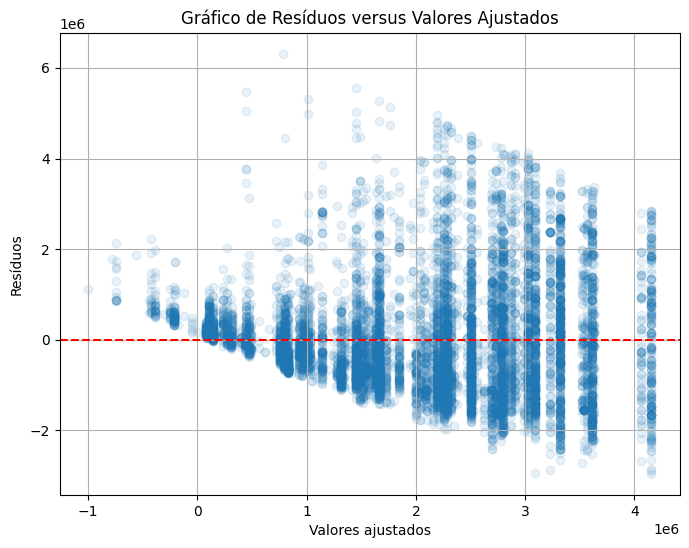

In [46]:
#Fazendo gráfico de resíduos versus valores ajustados
# Calculando os resíduos
residuals = results.resid

# Calculando os valores ajustados
predicted_values = results.predict()

# Plotar os resíduos versus valores ajustados
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, alpha=0.1)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos versus Valores Ajustados')
plt.grid(True)
plt.show()

 O QQplot é utilizado para avaliar a adequação de uma distribuição de dados observada em relação a uma distribuição teórica específica. Ele fornece uma maneira visual e intuitiva de interpretar a normalidade dos dados e identificar desvios de outras distribuições teóricas. Se os pontos no gráfico seguirem aproximadamente uma linha diagonal, isso sugere que os dados se aproximam de uma distribuição normal. Desvios significativos da linha diagonal podem indicar desvios da normalidade nos dados.

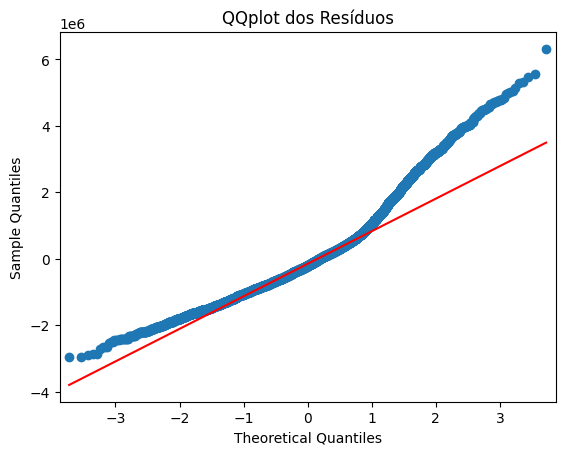

In [47]:
# Criando o QQplot
sm.qqplot(residuals, line='q')
plt.title('QQplot dos Resíduos')
plt.show()


Como pode ser visto nos gráficos acima, aparentemente o modelo possui problemas de homocedasticidade e heterocedasticidade. Isso pode afetar a precisão das estimativas dos coeficientes e a interpretação dos resultados do modelo. Isto pode ter ocorrido pelo fato da variável resposta não atender a suposição de normalidade. Para lidar com estes problemas existem algumas estaratégias como: transformar as variáveis, pesos robustos e modelos alternativos. Entretanto, o foco deste projeto é utilizar a forma mais simples de ajustar e avaliar um modelo. Por isso, essas questões não serão levadas em consideração.

O próximo passo é interpretar o modelo obtido. Para isso, será necessário formatar a saída do modelo que atualmente está no formato de notação científica. Para formatar será utilizado o script abaixo.

In [48]:
# Obtendo os coeficientes e os p-values
coeficientes = results.params
p_values = results.pvalues

# Função para formatar os valores
def formatar_valor(valor):
    return "{:.2f}".format(valor)

# Aplicando a formatação aos coeficientes e aos p-values
coeficientes_formatados = coeficientes.apply(formatar_valor)
p_values_formatados = p_values.apply(formatar_valor)

# Criando DataFrames para os coeficientes e os p-values formatados
coeficientes_df = pd.DataFrame(coeficientes_formatados, columns=['Coeficientes'])
p_values_df = pd.DataFrame(p_values_formatados, columns=['P-values'])

# Juntando os DataFrames e imprimindo
summary_df = pd.concat([coeficientes_df, p_values_df], axis=1)
print(summary_df.to_string())


                    Coeficientes P-values
Categoria_Casas       -525737.24     0.00
Quartos_1              258371.55     0.03
Quartos_2              615566.68     0.00
Quartos_3             1269302.51     0.00
Quartos_4             1855909.08     0.00
Quartos_5 ou mais     1760403.07     0.00
Banheiros_1           -179463.93     0.00
Banheiros_2           -214460.92     0.00
Banheiros_4            525892.04     0.00
Banheiros_5 ou mais   1066963.65     0.00
Região_Zona Norte     -297337.54     0.01
Região_Zona Oeste      396881.77     0.00
Região_Zona Sul       1232818.15     0.00


Após formatado, podemos interpretar o modelo.

Podemos também utilizar o modelo.

In [51]:
#Utilizando o modelo para prever o preço de um apartamento de 3 quartos, 2 banheiros na zona sul.
valores_para_previsao = [
    0,  # Categoria_Casas
    0,  # Quartos_1
    0,  # Quartos_2
    1,  # Quartos_3
    0,  # Quartos_4
    0,  # Quartos_5 ou mais
    0,  # Banheiros_1
    1,  # Banheiros_2
    0,  # Banheiros_4
    0,  # Banheiros_5 ou mais
    0,  # Região_Zona Norte
    0,  # Região_Zona Oeste
    1   # Região_Zona Sul
]

valores_para_previsao_df = pd.DataFrame([valores_para_previsao], columns=X.columns)
previsao = results.predict(valores_para_previsao_df)
valor_previsto_formatado = f"{previsao.iloc[0]:.2f}"
print("Valor previsto: R$", valor_previsto_formatado)

Valor previsto: R$ 2287659.74


Considerações finais: 

O fato desta base ser proveniente de dados reais e a coleta não ter sido muito bem planejada, aliada a uma abordagem mais simplista da preparação e ajuste do modelo, causou problemas na qualidade do ajuste. Para trabalhos futuro, uma coleta mais estruturada da base e uma abordagem mais complexa na hora de ajustar o modelo pode encontrar resultados mais satisfatórios.